In [6]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import memote
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")




In [7]:
import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'gurobi'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the Geweke statistic. 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions. 


In [83]:
'''This code block contains functions that we need to use to analyze our flux sampling experiment. 
These include tests to check for convergence, for autocorrelation, as well as for pairwise comparisons of fluxes between
parametization regimens (WT, TR, as well as 3 light conditions) and a script to determine whether fluxes are
coupled with each other. Lastly, I also tried PCA to determine which reactions contribute most to the variance of each null space distribution per
sampling run.
'''

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def load_csv_and_cleanup(filename):
    # Load the CSV file
    df = pd.read_csv(filename)

    # Remove columns with a mean below tolerance
    mean_values = df.mean()
    columns_to_remove = mean_values[abs(mean_values) < 1e-7].index
    df = df.drop(columns=columns_to_remove)

    # Fix the indices
    df.reset_index(drop=True, inplace=True)
    print(df.shape)

    return df    

    
    
def raftery_lewis_statistic(dataframe, quantiles=[0.025, 0.975], threshold=0.01):
    result = {}
    
    for column in dataframe.columns:
        series = dataframe[column]
        sorted_samples = np.sort(series)
        n = len(series)
        
        # Calculate the posterior quantiles
        posterior_quantiles = np.percentile(sorted_samples, q=[100 * q for q in quantiles])
        
        # Calculate the Monte Carlo standard error
        monte_carlo_se = np.std(sorted_samples)
        
        # Calculate the effective sample size
        n_eff = n / (1 + 2 * np.sum(np.abs(sorted_samples - posterior_quantiles[0]) / monte_carlo_se))
        
        # Calculate the Raftery-Lewis sample size
        n_r = int(np.ceil((1 + threshold) * n_eff))
        
        result[column] = {
            'n_eff': n_eff,
            'n_r': n_r
        }
    
    return pd.DataFrame(result)

#I'm not sure this is correct. Is this correct? 
#I think I could just use R to do the convergence analysis instead para di mahirap.




    
def geweke_convergence(df, threshold=1.24):
    # Get the list of flux parameter columns
    flux_columns = df.columns.tolist()

    # Calculate the Geweke diagnostic for each column
    geweke_values = []
    for col in flux_columns:
        chain_values = df[col].values
        n_samples = chain_values.shape[0]

        # Calculate the Geweke diagnostic
        first_segment = chain_values[:int(n_samples * 0.1)]  # First 10th percentile
        last_segment = chain_values[int(n_samples * 0.5):]  # Last 50th percentile
        z_scores = (np.mean(first_segment) - np.mean(last_segment)) / np.sqrt(np.var(first_segment) + np.var(last_segment))

        geweke_values.append(z_scores)

    # Determine the convergence based on the Geweke diagnostic
    converged_fluxes = sum(np.abs(geweke_values) < threshold)  # Assuming |z-score| < 1.96 indicates convergence (for 0.95 confidence interval)
    total_fluxes = len(flux_columns)

    # Calculate the percentage of converged fluxes
    percentage_converged = (converged_fluxes / total_fluxes) * 100

    return percentage_converged

#Eto medyo may tiwala ako dito.






def compare_pair(reaction, df1, df2, significance_threshold):
    """
    Compare the flux distributions of a pair of columns from two dataframes using the Kruskal-Wallis test.

    :param pair: Tuple containing the pair of column names.
    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test.
    :return: The pair and the result of the Kruskal-Wallis test.
    """
    sample1 = df1[reaction]
    sample2 = df2[reaction]
    H, pval = kruskal(sample1, sample2)
    return pval 

def compare_flux_distributions(df1, df2, significance_threshold=0.05):
    """
    Compare the flux distributions of each pair of columns from two dataframes using the Kruskal-Wallis test.

    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test (default: 0.05).
    :return: A list of pairs with significantly different distributions.
    """
    common_columns = set(df1.columns) & set(df2.columns)
    
    pool = multiprocessing.Pool()
    sig_results = []
    non_sig_results = []
    
    for rxn in common_columns:
        kw_pval = compare_pair(rxn, df1, df2, significance_threshold) #This does the Kruskal-Wallis part
        if kw_pval < significance_threshold:
            sig_results.append(rxn)
        else:
            non_sig_results.append(rxn)
            
    
    return sig_results, non_sig_results



#The script above is used for flux coupling using the opened CSV file as input and outputs 3 lists:
#positively correlated, neg. correlated and uncoupled reactions


#This is for visualization
def generate_histograms(dataframe1, dataframe2, column_name):
    # Create subplots for two histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Histogram for dataframe1
    axes[0].hist(dataframe1[column_name], bins=10, color='skyblue')
    axes[0].set_title(f'Histogram of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')

    # Histogram for dataframe2
    axes[1].hist(dataframe2[column_name], bins=10, color='lightgreen')
    axes[1].set_title(f'Histogram of {column_name}')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Frequency')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the histograms
    plt.show()

    
def generate_stacked_histogram(dataframes, column_name, histtype='bar'):
    # Concatenate the column data from all dataframes into a single series
    
    df_name = list()
    for dfs in dataframes:
    # Create the stacked histogram
        if column_name in dfs.columns:
            plt.hist(dfs[column_name], bins=33, alpha=0.45, stacked=True, histtype=histtype)
            df_name.append(get_df_name(dfs))
        else:
            pass
    
    # Set plot title and labels
    plt.title(f"Stacked Histogram for Column: {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.legend(df_name)
 
    plt.show()

def plot_scatter_regression(df, column_x, column_y):
    """
    Generates a scatterplot and a linear regression line between two columns in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe.
        - column_x (str): The column name for the X-axis.
        - column_y (str): The column name for the Y-axis.
    """

    # Extract X and Y values from the dataframe
    X = df[column_x].values.reshape(-1, 1)
    Y = df[column_y].values

    # Fit linear regression model
    regression = LinearRegression()
    regression.fit(X, Y)

    # Predict Y values based on the regression line
    Y_pred = regression.predict(X)

    # Plot the scatterplot and regression line
    plt.scatter(X, Y, color='blue', label='Actual')
    plt.plot(X, Y_pred, color='red', label='Regression Line')
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.title('Scatterplot with Linear Regression Line')
    plt.legend()
    plt.show()


    
    
#These functions are for generating PCA plots and other corollary analyses

def merge_dataframes(dataframes, names):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(1e-7)
    
    return merged_df

def generate_pca_plot(dataframe):
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns
    X = dataframe[numeric_columns].values

    pca = PCA(n_components=2)

    components = pca.fit_transform(X)

    # Extract dataframe names
    dataframe_names = dataframe['sample'].unique()

    # Generate plot with different colors for each dataframe
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']  # Add more colors if needed

    fig, ax = plt.subplots()
    for i, name in enumerate(dataframe_names):
        indices = dataframe['sample'] == name
        ax.scatter(components[indices, 0], components[indices, 1], label=name, c=colors[i])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()
    plt.show()
    
    #export PCA to determine component variance
    pca_fit = pca.fit(X)
    
    return pca_fit

def select_significant_features(pca, feature_names, top_n):
    loadings = pca.components_
    abs_loadings = np.abs(loadings)
    feature_contribution = np.sum(abs_loadings, axis=0)
    sorted_features = feature_names[np.argsort(feature_contribution)[::-1]]
    selected_features = sorted_features[:top_n]
    return selected_features

def plot_selected_features_heatmap(pca, feature_names, selected_features):
    loadings = pca.components_
    selected_indices = [np.where(feature_names == feature)[0][0] for feature in selected_features]
    selected_loadings = loadings[:, selected_indices]

    plt.figure(figsize=(10, 6))
    sns.heatmap(selected_loadings, cmap='coolwarm', annot=False, xticklabels=selected_features)
    plt.xlabel('Selected Features')
    plt.ylabel('Principal Components')
    plt.title('Loadings Heatmap of Selected Features')
    plt.show()



In [9]:
#Test the script on one CSV

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_250.csv')
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_750.csv')
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_1500.csv')
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_250.csv')
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_750.csv')

tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_1500.csv')




(5012, 699)
(5012, 688)
(5012, 1849)
(5012, 693)
(5012, 693)
(5012, 1856)


In [11]:
print(geweke_convergence(wt_250, threshold=1.24))
print(geweke_convergence(wt_750, threshold=1.24))
print(geweke_convergence(wt_1500, threshold=1.24))
print(geweke_convergence(tr_250, threshold=1.24))
print(geweke_convergence(tr_750, threshold=1.24))
print(geweke_convergence(tr_1500, threshold=1.24))



100.0
100.0
100.0
100.0
100.0
100.0


PART 1: PCA
This is an attempt to use Principal component analysis to analyze the variance between the sample distributions. I am particularly interested on which particular reactions contribute most to the variance when all of the samplings have been pooled into a single distribution. 



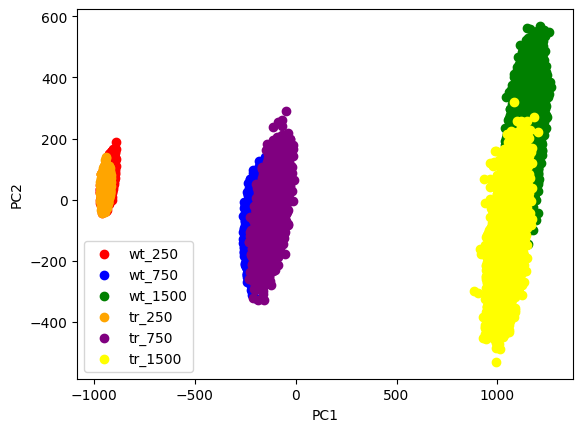

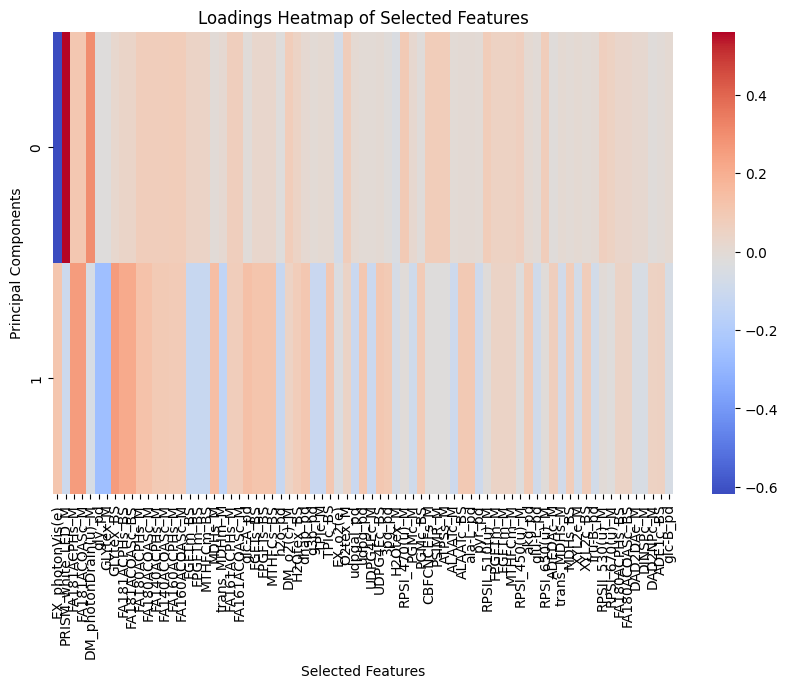

In [11]:
df_list = [wt_250, wt_750, wt_1500, tr_250, tr_750, tr_1500]
names=['wt_250','wt_750','wt_1500','tr_250','tr_750','tr_1500']


merged_df = merge_dataframes(df_list, names)
flux_sampling_pca = generate_pca_plot(merged_df)

top_contribs = select_significant_features(flux_sampling_pca, merged_df.columns, 75)

plot_selected_features_heatmap(flux_sampling_pca, merged_df.columns, top_contribs)

STAT NO. 2: Pairwise comparison of flux distributions
This offers a more comprehensive view on which reactions have a different flux distribution in between samples. The test used for this stat is the Kruskal-Wallis ranked test, which is a non-parametric test typically used for flux sampling to compare fluxes.

In [12]:
wt_250_750_sig, wt_250_750_non_sig =compare_flux_distributions(wt_250, wt_750, significance_threshold=0.05)
wt_250_1500_sig, wt_250_1500_non_sig =compare_flux_distributions(wt_250, wt_1500, significance_threshold=0.05)
wt_750_1500_sig, wt_750_1500_non_sig =compare_flux_distributions(wt_750, wt_1500, significance_threshold=0.05)


tr_250_750_sig, tr_250_750_non_sig = compare_flux_distributions(tr_250, tr_750, significance_threshold=0.05)
tr_750_1500_sig, tr_750_1500_non_sig = compare_flux_distributions(tr_750, tr_1500, significance_threshold=0.05)
tr_250_1500_sig, tr_250_1500_non_sig = compare_flux_distributions(tr_250, tr_1500, significance_threshold=0.05)

wt_tr_250_sig, wt_tr_250_non_sig = compare_flux_distributions(wt_250, tr_250, significance_threshold=0.05)
wt_tr_750_sig, wt_tr_750_non_sig = compare_flux_distributions(wt_750, tr_750, significance_threshold=0.05)
wt_tr_1500_sig, wt_tr_1500_non_sig = compare_flux_distributions(wt_1500, tr_1500, significance_threshold=0.05)

wt_invariant_fluxes = set(wt_250_750_non_sig) & set(wt_750_1500_non_sig)
#no invariant fluxes between all samples WT

tr_invariant_fluxes = set(tr_250_750_non_sig) & set(tr_750_1500_non_sig)
#0 invariant fluxes

wt_tr_250_750_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_750_non_sig)
#Only ATGS and CBMKs (Carbamate Kinase) as invariant fluxes detected

wt_tr_750_1500_invariant_fluxes = set(wt_tr_750_non_sig) & set(wt_tr_1500_non_sig)
#Only proline PD trannsport detected as invariant @ high conditions

In [15]:
wt_tr_750_1500_invariant_fluxes

{'pro-L_pd'}

In [16]:
wt_list = [wt_250, wt_750, wt_1500]
tr_list = [tr_250, tr_750, tr_1500]
_250_list = [wt_250,tr_250]
_750_list = [wt_750,tr_750]
_1500_list=[wt_1500,tr_1500]

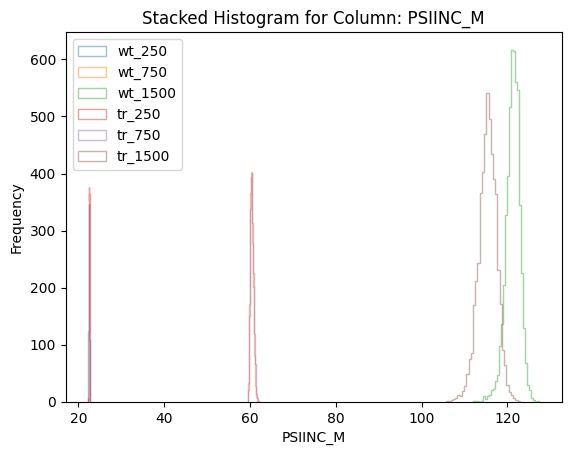

In [89]:
generate_stacked_histogram(df_list, 'PSIINC_M', histtype='step')
#Hmm. This is weird, PSII becomes decoupled at high light conditions. Bakit kaya?

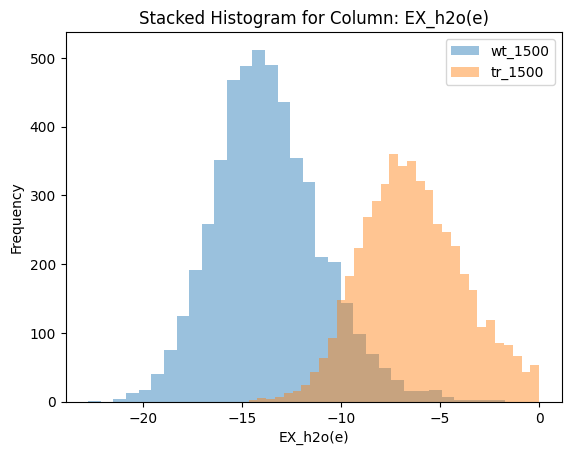

In [69]:
generate_stacked_histogram(df_list, 'EX_h2o(e)')

#I don't want to infer anything from this because there's  an issue with H2O recycling with my model, pero this shows that
#There's significantly lesser demmand for H2O being drawn by the TR model @ high light than with the WT model.
#I might be able to fix this issue in the future


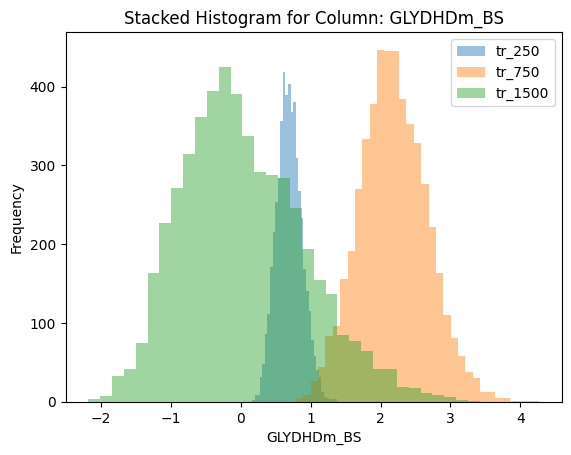

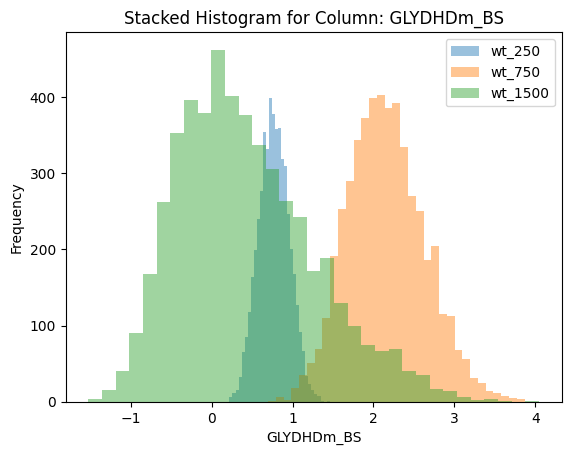

In [68]:
#This is for Glycine Decarboxylase in the Bundle sheath cell. Behavior is towards decarboxylation at intermediate light levels before
#Settling near 0 to carboxylation @ high light levels. Is it because of high CO2 concentrations 

generate_stacked_histogram(tr_list, 'GLYDHDm_BS')

generate_stacked_histogram(wt_list, 'GLYDHDm_BS')

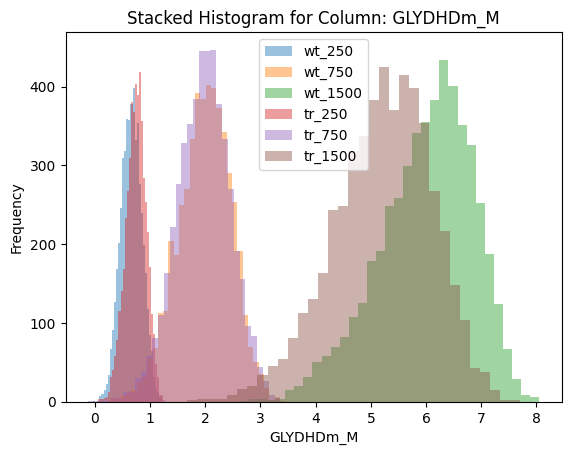

In [71]:
#Histogram for GLycine decarboxylase (First committal step to the C2 shuttle in plants -- GLycine shunt)
#Interestingly, the fluxes become more decoupled at higher  light regimens in the Trans-parametrized plants
generate_stacked_histogram(df_list, 'GLYDHDm_M')

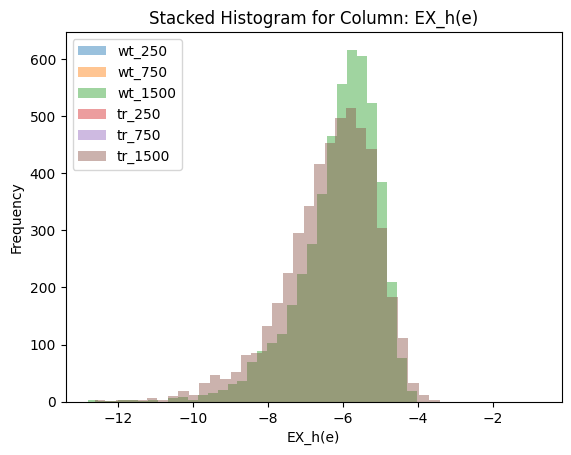

In [75]:
#Similar demand for protons @ high levels
generate_stacked_histogram(df_list, 'EX_h(e)')


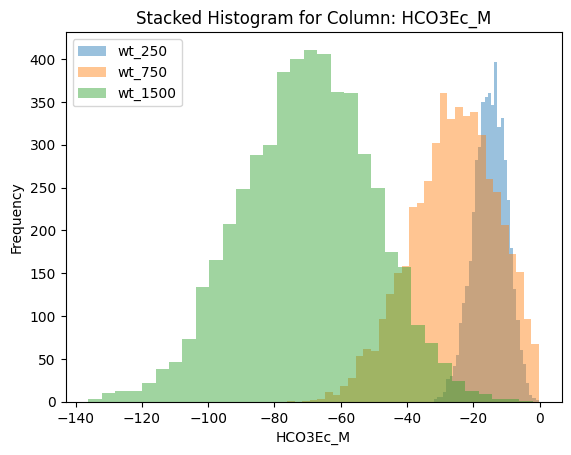

In [28]:
generate_stacked_histogram(wt_list,'HCO3Ec_M')

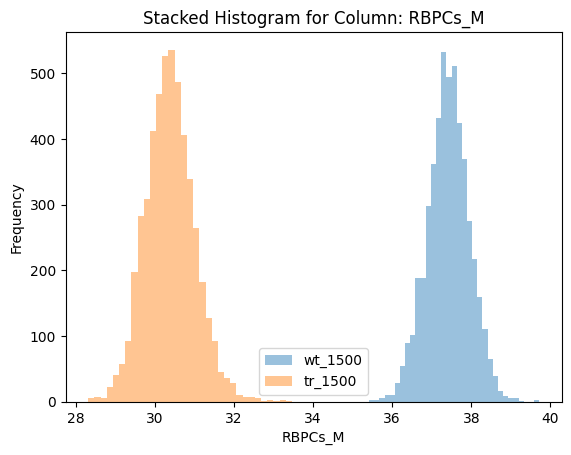

In [36]:
generate_stacked_histogram(_1500_list, 'RBPCs_M')

RESULTS:

1. Interestingly, it was found out that across all light conditions, the BS RBCL features highest flux ranges at medium light ranges (750 PPFD) than either in low or high light conditions. This relationship holds true for both Wild-type and Trans-parametrized models. 

2. Due to the carbon assimilation constraints, Rubisco becomes strongly decoupled at high light levels while featuring similar distributions at low and medium light parametrizations. However, it is also  detected to have a significantly different flux distributions when taking into account the results from the Kruskal-Wallis Test.

3. The list of decoupled reactions and their percentage based on the total active fluxes are as follows:

WT250 = 





STAT NO. 3: FLUX COUPLING ANALYSIS

This is a technique that is used to detect couplings between specific reactions in a given model. This technique is elaborated upon by Price, SChellenberger & Palsson (2004) in which a randomly sampled solution space, appropriately constrained based on environmental and phenotypic conditions, allows us to infer pairwise relations between the flux solutions. In turn, this method allows us to see which reactions are strongly coupled with each other given a set of constraints. 

Here are some reactions that I am particularly interested in, since I've found that they were unexpectedly decoupled from each other:
-PSIINC_M
-RBPCs_BS


In [ ]:
#This is a sample plot showing the correlation between Rubisco in the M cell and the BS cell 
#@ medium light (Trans parametrized model)

plot_scatter_regression(tr_1500, 'RBPCs_M', 'RBPOs_BS')

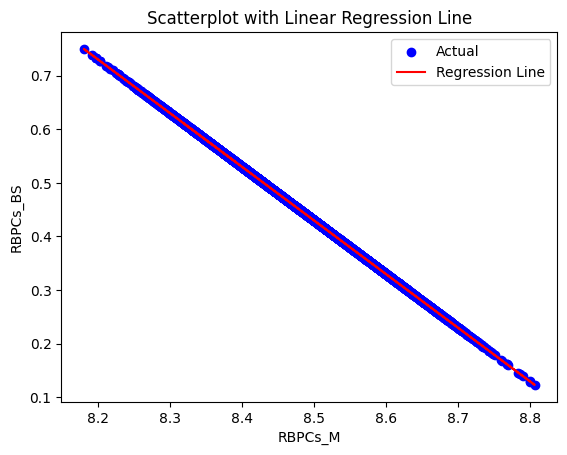

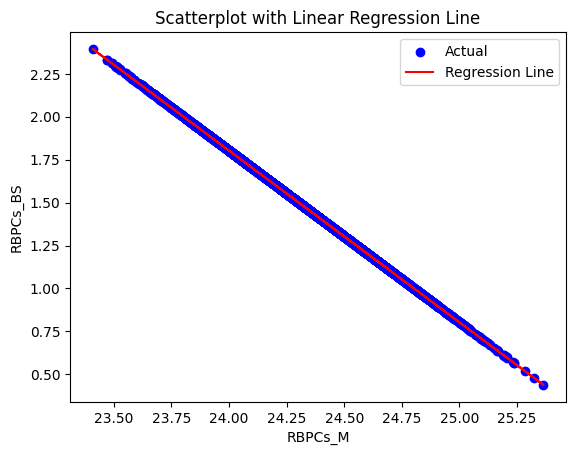

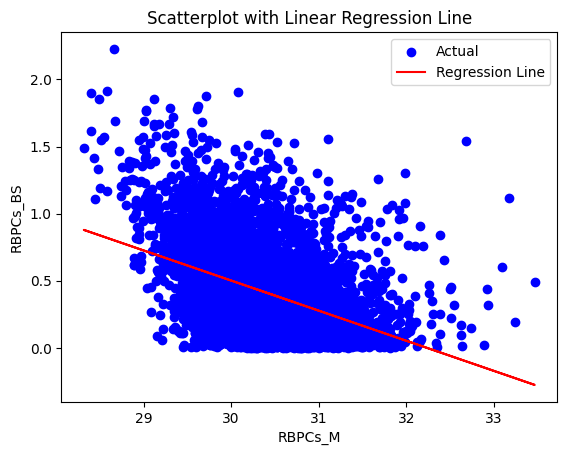

In [40]:
#This is a sample plot showing the correlation between Rubisco in the M cell and the BS cell 
#@ high light (Trans parametrized model)
#This is a sample plot showing the correlation between Rubisco in the M cell and the BS cell 
#@ high light (Trans parametrized model)

plot_scatter_regression(tr_250, 'RBPCs_M', 'RBPCs_BS')
plot_scatter_regression(tr_750, 'RBPCs_M', 'RBPCs_BS')
plot_scatter_regression(tr_1500, 'RBPCs_M', 'RBPCs_BS')

In [95]:
def visualize_correlation_matrix(df, sort_by=None, ascending=False):
    """
    Calculates and visualizes the correlation matrix based on flux measurements in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe containing flux measurements.
        - sort_by (str or None): Column name to sort the correlation matrix by. Default is None.
        - ascending (bool): Whether to sort in ascending order. Default is False.
    """

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Sort the correlation matrix if sort_by is specified
    if sort_by is not None:
        correlation_matrix = correlation_matrix.sort_values(by=sort_by, ascending=ascending)

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

    # Set plot title
    plt.title('Correlation Matrix')

    # Display the heatmap
    plt.show()

def filter_correlation_pairs(correlation_matrix, threshold, filter_elements):
    """
    Filters out specific pairs in the correlation matrix based on a specified absolute value threshold,
    removes pairs that share columns, removes symmetrical results, and returns the rows where the filter elements are found in either of the two variable columns.

    Parameters:
        - correlation_matrix (pandas.DataFrame): The correlation matrix.
        - threshold (float): The absolute value threshold to filter the correlation coefficients.
        - filter_elements (list): The elements to filter out from the correlation matrix.

    Returns:
        - filtered_pairs (pandas.DataFrame): The table showing the filtered pairs and their correlation coefficients,
                                             where the filter elements are found in either of the two variable columns,
                                             with symmetrical results removed.
    """
    # Filter out pairs based on the threshold
    filtered_pairs = correlation_matrix.unstack().reset_index()
    filtered_pairs = filtered_pairs.rename(columns={'level_0': 'Variable A', 'level_1': 'Variable B', 0: 'Correlation'})
    filtered_pairs = filtered_pairs[filtered_pairs['Correlation'].abs() >= threshold]

    # Remove pairs that share columns
    filtered_pairs = filtered_pairs[~(filtered_pairs['Variable A'] == filtered_pairs['Variable B'])]

    # Remove symmetrical results
    filtered_pairs = filtered_pairs[filtered_pairs['Variable A'] < filtered_pairs['Variable B']]

    # Filter rows where the filter elements are found in either of the two variable columns
    filtered_pairs = filtered_pairs[(filtered_pairs['Variable A'].isin(filter_elements)) | (filtered_pairs['Variable B'].isin(filter_elements))]
    
    # Sort the filtered pairs by correlation coefficient in descending order
    filtered_pairs = filtered_pairs.sort_values('Correlation', ascending=False)
    
    filtered_pairs = filtered_pairs.reset_index()
    

    return filtered_pairs



In [94]:
wt_250_corr = wt_250.corr()
wt_750_corr = wt_750.corr()
wt_1500_corr = wt_1500.corr()

tr_250_corr = tr_250.corr()
tr_750_corr =  tr_750.corr()
tr_1500_corr = tr_1500.corr()

/tmp/ipykernel_27273/3961304699.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wt_250_corr = wt_250.corr()
/tmp/ipykernel_27273/3961304699.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wt_750_corr = wt_750.corr()
/tmp/ipykernel_27273/3961304699.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wt_1500_corr = wt_1500.corr()
/tmp/ipykernel_27273/3961304699.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it

In [98]:
filter_correlation_pairs(wt_1500_corr, 0.5, ['PSIINC_M'])

index    Variable A Variable B  Correlation
0   1637096        O2tu_M   PSIINC_M     1.000000
1   1348652       FNORs_M   PSIINC_M     0.973010
2    424152        ENOs_M   PSIINC_M     0.655872
3    749576        PGMs_M   PSIINC_M     0.655872
4   1454045  3PG(pi)tsr_M   PSIINC_M     0.559934
5    742180        PGKs_M   PSIINC_M    -0.589123
6    596109    GAPDH1ys_M   PSIINC_M    -0.589123
7   1352431      PSIINC_M    PYRts_M    -0.654558
8    237403       PEPSs_M   PSIINC_M    -0.658864
9    135708       ADK1s_M   PSIINC_M    -0.692283
10  1465139       O2tsr_M   PSIINC_M    -0.739553
11   120916       ATPSs_M   PSIINC_M    -0.838081
12  1352349      PSIINC_M    PSIMR_M    -0.843387
13  1344954   CBFCNCEFs_M   PSIINC_M    -0.843387
14  1346803       CCEFs_M   PSIINC_M    -0.965488
15  1638945       H2Otu_M   PSIINC_M    -1.000000

In [99]:
filter_correlation_pairs(tr_1500_corr, 0.5, ['PSIINC_M'])

index           Variable A Variable B  Correlation
0   1643291               O2tu_M   PSIINC_M     1.000000
1   1353755              FNORs_M   PSIINC_M     0.975908
2    427611               ENOs_M   PSIINC_M     0.596052
3    754267               PGMs_M   PSIINC_M     0.596052
4   1459547         3PG(pi)tsr_M   PSIINC_M     0.593662
5   1648859  DM_photonDrain(u)_M   PSIINC_M    -0.514721
6    240155              PEPSs_M   PSIINC_M    -0.575939
7   1357548             PSIINC_M    PYRts_M    -0.593072
8    138075              ADK1s_M   PSIINC_M    -0.626944
9    600219           GAPDH1ys_M   PSIINC_M    -0.634566
10   746843               PGKs_M   PSIINC_M    -0.634566
11  1470683              O2tsr_M   PSIINC_M    -0.740775
12   123227              ATPSs_M   PSIINC_M    -0.833739
13  1350043          CBFCNCEFs_M   PSIINC_M    -0.839265
14  1357466             PSIINC_M    PSIMR_M    -0.839265
15  1351899              CCEFs_M   PSIINC_M    -0.963826
16  1645147              H2Otu_M   PSIINC_M    -1.000000

Hmm. PSII is more strongly coupled with reactions involving Glycolysis/Gluconeogenesis in the TR1500 than in WT1500. I wonder if there are any depressed fluxes dun sa group na yun?

In [112]:
trans_model.groups.get_by_id('Glycolysis/Gluconeogensis').members

{<Reaction ADE1c_BS at 0x7fbc07053c40>,
 <Reaction ADE1c_M at 0x7fbc07f52bc0>,
 <Reaction ADE1s_BS at 0x7fbc07053eb0>,
 <Reaction ADE1s_M at 0x7fbc07f52e30>,
 <Reaction AKGDHam1m_BS at 0x7fbc074e35e0>,
 <Reaction AKGDHam1m_M at 0x7fbc081ae560>,
 <Reaction ENOc_BS at 0x7fbc07376b30>,
 <Reaction ENOc_M at 0x7fbc081f1ab0>,
 <Reaction ENOs_BS at 0x7fbc07377070>,
 <Reaction ENOs_M at 0x7fbc081f1ff0>,
 <Reaction FBAc_BS at 0x7fbc0712d9f0>,
 <Reaction FBAc_M at 0x7fbc080abe50>,
 <Reaction FBAs_BS at 0x7fbc0712d8a0>,
 <Reaction FBAs_M at 0x7fbc080abca0>,
 <Reaction FBPc_BS at 0x7fbc07237c70>,
 <Reaction FBPc_M at 0x7fbc0804ebf0>,
 <Reaction FBPs_BS at 0x7fbc07237f70>,
 <Reaction FBPs_M at 0x7fbc0804eef0>,
 <Reaction G6PEc_BS at 0x7fbc070260e0>,
 <Reaction G6PEc_M at 0x7fbc07f39060>,
 <Reaction G6PEs_BS at 0x7fbc07026470>,
 <Reaction G6PEs_M at 0x7fbc07f393f0>,
 <Reaction GAPDH1c_BS at 0x7fbc072ffd60>,
 <Reaction GAPDH1c_M at 0x7fbc080ab1f0>,
 <Reaction GAPDH2s_BS at 0x7fbc072ffe80>,
 <Reaction

In [103]:
wt_model.reactions.ENOs_M.notes

{'GENE_ASSOCIATION': 'LOC_Os09g20820',
 'SUBSYSTEM': 'Glycolysis/Gluconeogensis',
 'EC Number': '4.2.1.11',
 'Confidence Level': '4',
 'AUTHORS': '[6]'}

In [ ]:
plt.hist(tr_750['trans_MDHs_M'], bins=33, density=True)

In [ ]:
trans_model.reactions.RPEs_BS

In [ ]:
filter_correlation_pairs(wt_750_corr, 1, merged_df.columns)

In [ ]:
wt_model.reactions.PGMc_M

In [ ]:
print(len(wt_tr_250_non_sig))

In [ ]:
print(len(wt_tr_750_non_sig))

In [ ]:
print(len(wt_tr_1500_non_sig))

In [ ]:
for rxn in wt_tr_750_1500_invariant_fluxes:
    reaction = trans_model.reactions.get_by_id(rxn)
    print('reaction id: ', reaction.id)
    print('reaction name: ', reaction.name)
    groups = reaction.notes.get('SUBSYSTEM', '')
    print('reaction groups: ', groups)

In [ ]:
#Flux sampling at low, medium and high light regimens

#Light treatments at 250 PPFD, 750 PPFD and 1500 PPFD

Correlation of flux measurements: use in designing experiments
Uniform random sampling of the steady-state flux space allows for the calculation of the correlation coefficient (rij) between any two fluxes (vi and vj) in the network. Thus, sampling provides a straightforward means of not only calculating perfectly correlated subsets (
), but also of identifying well-correlated, but not perfectly correlated reaction sets. The matrix of squared pairwise correlation coefficients for all the RBC metabolic fluxes was computed. The fluxes can be ordered such that the “correlated reaction sets” (defined here as 
) are listed in order of decreasing number of fluxes in each set (Table 1).


From Price, Schellenberger and Palsson, (2004) -- Uniform Sammpling of flux





Hmm. Interesting results. It shows that fluxes have become more decoupled in the low light regimens compared with medium and high light regimens when comparing results between parametrizations (WT and TR), at a threshold value of 0.001.
